<a href="https://colab.research.google.com/github/NSR9/Extensive-Vision-AI/blob/main/Assignment_7/Experiments/Assignment7_nb2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-pieag8up
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-pieag8up
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=23fe9e5873a95e54373814cf4d534b803e16b12306c76687bf01765cf7ecdf46
  Stored in directory: /tmp/pip-ephem-wheel-cache-7zi2ti5f/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm 

from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [3]:
class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))

### **Transformations**

In [4]:
SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


NameError: ignored

In [8]:
train = datasets.CIFAR10(root='./data', train=True,download=True)


Extracting ./data/cifar-10-python.tar.gz to ./data


In [9]:
train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
train_data = train.data
print(' - Numpy Shape:', train_data.shape)
print(' - min:', np.min(train_data, axis=(0,1,2)) / 255.)
print(' - max:', np.max(train_data, axis=(0,1,2)) / 255.)
print(' - mean:', np.mean(train_data, axis=(0,1,2)) / 255.)
print(' - std:', np.std(train_data, axis=(0,1,2)) / 255.)
print(' - var:', np.var(train_data, axis=(0,1,2)) / 255.)

 - Numpy Shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


In [11]:
train_transform = A.Compose([
            A.HorizontalFlip(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, always_apply=False, p=0.5),
            A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None),
            A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
            A.ToGray(),
            ToTensorV2(),
        ])

test_transform = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2(),
])

In [12]:
train_transform = Transforms(train_transform)
test_transform = Transforms(test_transform)

In [13]:
train = datasets.CIFAR10(root='./data', train=True,
                        download=True, transform=train_transform)
test = datasets.CIFAR10(root='./data', download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train, 
                                          batch_size=128, 
                                          shuffle=True,
                                          num_workers=2, 
                                          pin_memory=True)
test_loader = torch.utils.data.DataLoader(test, 
                                          batch_size=128,  
                                          shuffle=False,
                                          num_workers=2, 
                                          pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


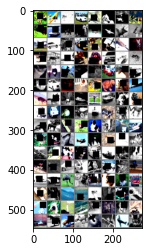

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images["image"]))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [15]:
use_cuda = torch.cuda.is_available()
device = 'cuda:0' if use_cuda else 'cpu'

### **Model Design**

In [16]:
class Net(nn.Module):
    def __init__(self, dropout):
      
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),# 32 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),# 32 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),# 32 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
        )
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False) # 32 32
        )
        self.conv2 = nn.Sequential(
            #nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 32 30
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), groups=32, padding=0, bias=False), #depth_conv
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), #point_conv
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
            
            #nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 30 28
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), groups=32, padding=0, bias=False), #depth_conv
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), #point_conv
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),

            #nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 28 26
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), groups=32, padding=0, bias=False), #depth_conv
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), #point_conv
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
        )
        # dilation
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = (3, 3), stride = 1, padding = 0, dilation=2), # 26 22
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            #nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 22 20
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), groups=16, padding=0, bias=False), #depth_conv
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), #point_conv
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
            
            #nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),# 20 18
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), groups=32, padding=0, bias=False), #depth_conv
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0, bias=False), #point_conv
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),

            #nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),# 18 16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), groups=64, padding=0, bias=False), #depth_conv
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False), #point_conv
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
        )
              
        self.trans3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3, 3), stride = 2, padding = 0), # 16 7
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False) # 7 7
        )

        self.conv4 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 7 5
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.Dropout(0.1),
              
              nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),# 5 3
            )
        
        self.avgpool2d = nn.AvgPool2d(kernel_size=3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.trans3(x)
        x = self.conv4(x)
        x = self.avgpool2d(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### **Model Summary**

In [17]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(dropout=0.01).to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,432
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           2,048
           Conv2d-14           [-1

### **Train Function**

In [18]:
def train(model, device, train_loader, optimizer, epoch,scheduler,criterion):

  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  train_loss = 0
  
  lambda_l1 = 0.001
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data["image"].to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)

    train_loss += loss.item()

    # Backpropagation
    loss.backward()
        
    optimizer.step()
    scheduler.step()
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc = (100*correct/processed)
  return train_acc, train_loss

### **Test Function**

In [19]:
def test(model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data["image"].to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc = (100. * correct / len(test_loader.dataset))
    return test_acc, test_loss

### **Train And Test the Model**

In [20]:
dropout=0.01
epochs=100

criterion = nn.CrossEntropyLoss() 

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
    
model = Net(dropout).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.7)
scheduler = OneCycleLR(optimizer, max_lr=0.015, epochs=100, steps_per_epoch=len(train_loader))

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train_acc, train_loss = train(model, device, train_loader, optimizer,epoch,scheduler,criterion)
    train_accuracy.append(train_acc)
    train_losses.append(train_loss)

    test_acc, test_loss = test(model, device, test_loader,criterion)
    test_accuracy.append(test_acc)
    test_losses.append(test_loss)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1:


Loss=2.0314149856567383 Batch_id=390 Accuracy=17.94: 100%|██████████| 391/391 [00:17<00:00, 22.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0146, Accuracy: 14939/50000 (29.88%)

Epoch 2:


Loss=1.7498247623443604 Batch_id=390 Accuracy=28.57: 100%|██████████| 391/391 [00:17<00:00, 22.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 19940/50000 (39.88%)

Epoch 3:


Loss=1.8797616958618164 Batch_id=390 Accuracy=33.71: 100%|██████████| 391/391 [00:17<00:00, 22.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 21052/50000 (42.10%)

Epoch 4:


Loss=1.6862719058990479 Batch_id=390 Accuracy=36.41: 100%|██████████| 391/391 [00:17<00:00, 22.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 22796/50000 (45.59%)

Epoch 5:


Loss=1.4859000444412231 Batch_id=390 Accuracy=38.77: 100%|██████████| 391/391 [00:17<00:00, 22.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0110, Accuracy: 24247/50000 (48.49%)

Epoch 6:


Loss=1.6811813116073608 Batch_id=390 Accuracy=41.46: 100%|██████████| 391/391 [00:17<00:00, 22.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 25067/50000 (50.13%)

Epoch 7:


Loss=1.5011119842529297 Batch_id=390 Accuracy=43.43: 100%|██████████| 391/391 [00:17<00:00, 22.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 26936/50000 (53.87%)

Epoch 8:


Loss=1.6382240056991577 Batch_id=390 Accuracy=45.47: 100%|██████████| 391/391 [00:17<00:00, 22.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 28241/50000 (56.48%)

Epoch 9:


Loss=1.7575018405914307 Batch_id=390 Accuracy=47.35: 100%|██████████| 391/391 [00:17<00:00, 22.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 29361/50000 (58.72%)

Epoch 10:


Loss=1.3439009189605713 Batch_id=390 Accuracy=49.18: 100%|██████████| 391/391 [00:17<00:00, 22.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 30001/50000 (60.00%)

Epoch 11:


Loss=1.2966703176498413 Batch_id=390 Accuracy=50.63: 100%|██████████| 391/391 [00:17<00:00, 22.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 30412/50000 (60.82%)

Epoch 12:


Loss=1.374829649925232 Batch_id=390 Accuracy=51.75: 100%|██████████| 391/391 [00:17<00:00, 22.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 31180/50000 (62.36%)

Epoch 13:


Loss=1.4839613437652588 Batch_id=390 Accuracy=52.72: 100%|██████████| 391/391 [00:17<00:00, 22.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 32132/50000 (64.26%)

Epoch 14:


Loss=1.2890068292617798 Batch_id=390 Accuracy=53.68: 100%|██████████| 391/391 [00:17<00:00, 22.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 32077/50000 (64.15%)

Epoch 15:


Loss=1.6404564380645752 Batch_id=390 Accuracy=55.09: 100%|██████████| 391/391 [00:17<00:00, 22.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 33217/50000 (66.43%)

Epoch 16:


Loss=1.059023141860962 Batch_id=390 Accuracy=55.83: 100%|██████████| 391/391 [00:17<00:00, 22.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 33665/50000 (67.33%)

Epoch 17:


Loss=1.4795386791229248 Batch_id=390 Accuracy=57.24: 100%|██████████| 391/391 [00:17<00:00, 22.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 34446/50000 (68.89%)

Epoch 18:


Loss=1.0923664569854736 Batch_id=390 Accuracy=57.46: 100%|██████████| 391/391 [00:17<00:00, 22.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 34944/50000 (69.89%)

Epoch 19:


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 35553/50000 (71.11%)

Epoch 20:


Loss=1.1017773151397705 Batch_id=390 Accuracy=58.82: 100%|██████████| 391/391 [00:17<00:00, 22.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 35630/50000 (71.26%)

Epoch 21:


Loss=1.3492408990859985 Batch_id=390 Accuracy=59.78: 100%|██████████| 391/391 [00:17<00:00, 22.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 36096/50000 (72.19%)

Epoch 22:


Loss=0.9791437387466431 Batch_id=390 Accuracy=60.15: 100%|██████████| 391/391 [00:17<00:00, 22.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 35844/50000 (71.69%)

Epoch 23:


Loss=1.0080915689468384 Batch_id=390 Accuracy=60.65: 100%|██████████| 391/391 [00:17<00:00, 22.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 35586/50000 (71.17%)

Epoch 24:


Loss=0.9760915040969849 Batch_id=390 Accuracy=61.16: 100%|██████████| 391/391 [00:17<00:00, 22.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 36848/50000 (73.70%)

Epoch 25:


Loss=1.1567538976669312 Batch_id=390 Accuracy=61.70: 100%|██████████| 391/391 [00:17<00:00, 22.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 37070/50000 (74.14%)

Epoch 26:


Loss=0.9705133438110352 Batch_id=390 Accuracy=61.90: 100%|██████████| 391/391 [00:17<00:00, 22.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 36860/50000 (73.72%)

Epoch 27:


Loss=1.2079782485961914 Batch_id=390 Accuracy=62.65: 100%|██████████| 391/391 [00:17<00:00, 22.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 37865/50000 (75.73%)

Epoch 28:


Loss=1.0442085266113281 Batch_id=390 Accuracy=62.78: 100%|██████████| 391/391 [00:17<00:00, 22.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 37645/50000 (75.29%)

Epoch 29:


Loss=0.9834434390068054 Batch_id=390 Accuracy=63.35: 100%|██████████| 391/391 [00:17<00:00, 22.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 37974/50000 (75.95%)

Epoch 30:


Loss=0.9840173721313477 Batch_id=390 Accuracy=63.33: 100%|██████████| 391/391 [00:17<00:00, 22.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 38115/50000 (76.23%)

Epoch 31:


Loss=1.1730425357818604 Batch_id=390 Accuracy=63.83: 100%|██████████| 391/391 [00:17<00:00, 22.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 38674/50000 (77.35%)

Epoch 32:


Loss=0.7891185879707336 Batch_id=390 Accuracy=64.16: 100%|██████████| 391/391 [00:17<00:00, 22.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 39022/50000 (78.04%)

Epoch 33:


Loss=1.1964703798294067 Batch_id=390 Accuracy=64.43: 100%|██████████| 391/391 [00:17<00:00, 22.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 39098/50000 (78.20%)

Epoch 34:


Loss=1.1392024755477905 Batch_id=390 Accuracy=64.75: 100%|██████████| 391/391 [00:17<00:00, 21.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 38998/50000 (78.00%)

Epoch 35:


Loss=1.0092333555221558 Batch_id=390 Accuracy=64.93: 100%|██████████| 391/391 [00:17<00:00, 21.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 39001/50000 (78.00%)

Epoch 36:


Loss=1.1198986768722534 Batch_id=390 Accuracy=65.34: 100%|██████████| 391/391 [00:17<00:00, 22.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 38817/50000 (77.63%)

Epoch 37:


Loss=0.9754344820976257 Batch_id=390 Accuracy=65.54: 100%|██████████| 391/391 [00:17<00:00, 22.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 39038/50000 (78.08%)

Epoch 38:


Loss=0.9632765054702759 Batch_id=390 Accuracy=65.77: 100%|██████████| 391/391 [00:17<00:00, 22.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 39489/50000 (78.98%)

Epoch 39:


Loss=0.7177891135215759 Batch_id=390 Accuracy=65.90: 100%|██████████| 391/391 [00:17<00:00, 22.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 39802/50000 (79.60%)

Epoch 40:


Loss=0.7795181274414062 Batch_id=390 Accuracy=66.40: 100%|██████████| 391/391 [00:17<00:00, 22.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 39723/50000 (79.45%)

Epoch 41:


Loss=0.9223669171333313 Batch_id=390 Accuracy=66.21: 100%|██████████| 391/391 [00:17<00:00, 22.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 39213/50000 (78.43%)

Epoch 42:


Loss=0.7809053659439087 Batch_id=390 Accuracy=66.51: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 39941/50000 (79.88%)

Epoch 43:


Loss=1.1497477293014526 Batch_id=390 Accuracy=66.91: 100%|██████████| 391/391 [00:17<00:00, 21.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 39183/50000 (78.37%)

Epoch 44:


Loss=1.0426815748214722 Batch_id=390 Accuracy=66.97: 100%|██████████| 391/391 [00:17<00:00, 21.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 39771/50000 (79.54%)

Epoch 45:


Loss=0.9450299143791199 Batch_id=390 Accuracy=67.28: 100%|██████████| 391/391 [00:17<00:00, 21.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 40001/50000 (80.00%)

Epoch 46:


Loss=0.8280283212661743 Batch_id=390 Accuracy=66.86: 100%|██████████| 391/391 [00:18<00:00, 21.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 40294/50000 (80.59%)

Epoch 47:


Loss=0.9957391619682312 Batch_id=390 Accuracy=67.47: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 40238/50000 (80.48%)

Epoch 48:


Loss=0.8150027394294739 Batch_id=390 Accuracy=67.72: 100%|██████████| 391/391 [00:17<00:00, 21.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 40142/50000 (80.28%)

Epoch 49:


Loss=0.894008457660675 Batch_id=390 Accuracy=67.98: 100%|██████████| 391/391 [00:17<00:00, 22.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 39937/50000 (79.87%)

Epoch 50:


Loss=1.0739448070526123 Batch_id=390 Accuracy=67.79: 100%|██████████| 391/391 [00:18<00:00, 21.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 40561/50000 (81.12%)

Epoch 51:


Loss=0.8745124936103821 Batch_id=390 Accuracy=67.79: 100%|██████████| 391/391 [00:17<00:00, 21.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 40633/50000 (81.27%)

Epoch 52:


Loss=0.7963235974311829 Batch_id=390 Accuracy=68.17: 100%|██████████| 391/391 [00:17<00:00, 22.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 40797/50000 (81.59%)

Epoch 53:


Loss=0.9555035829544067 Batch_id=390 Accuracy=68.42: 100%|██████████| 391/391 [00:17<00:00, 21.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 40992/50000 (81.98%)

Epoch 54:


Loss=0.8131133317947388 Batch_id=390 Accuracy=68.81: 100%|██████████| 391/391 [00:17<00:00, 22.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 41118/50000 (82.24%)

Epoch 55:


Loss=0.9945741891860962 Batch_id=390 Accuracy=68.32: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 40727/50000 (81.45%)

Epoch 56:


Loss=0.8455823063850403 Batch_id=390 Accuracy=68.40: 100%|██████████| 391/391 [00:17<00:00, 22.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 41072/50000 (82.14%)

Epoch 57:


Loss=1.2414133548736572 Batch_id=390 Accuracy=69.07: 100%|██████████| 391/391 [00:17<00:00, 21.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 41258/50000 (82.52%)

Epoch 58:


Loss=0.9473384618759155 Batch_id=390 Accuracy=69.03: 100%|██████████| 391/391 [00:17<00:00, 22.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 41136/50000 (82.27%)

Epoch 59:


Loss=0.9081486463546753 Batch_id=390 Accuracy=68.86: 100%|██████████| 391/391 [00:17<00:00, 22.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 40952/50000 (81.90%)

Epoch 60:


Loss=0.9347614049911499 Batch_id=390 Accuracy=69.33: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 41124/50000 (82.25%)

Epoch 61:


Loss=0.5835496783256531 Batch_id=390 Accuracy=69.32: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 41504/50000 (83.01%)

Epoch 62:


Loss=0.8161181211471558 Batch_id=390 Accuracy=69.42: 100%|██████████| 391/391 [00:17<00:00, 21.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 40810/50000 (81.62%)

Epoch 63:


Loss=0.9781140089035034 Batch_id=390 Accuracy=69.64: 100%|██████████| 391/391 [00:17<00:00, 22.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 41615/50000 (83.23%)

Epoch 64:


Loss=0.9231823086738586 Batch_id=390 Accuracy=69.50: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 41478/50000 (82.96%)

Epoch 65:


Loss=0.8351003527641296 Batch_id=390 Accuracy=69.93: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 41588/50000 (83.18%)

Epoch 66:


Loss=0.850237250328064 Batch_id=390 Accuracy=70.04: 100%|██████████| 391/391 [00:17<00:00, 22.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 41741/50000 (83.48%)

Epoch 67:


Loss=1.0561009645462036 Batch_id=390 Accuracy=69.85: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 41560/50000 (83.12%)

Epoch 68:


Loss=1.046966552734375 Batch_id=390 Accuracy=70.08: 100%|██████████| 391/391 [00:17<00:00, 21.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 41522/50000 (83.04%)

Epoch 69:


Loss=0.8471576571464539 Batch_id=390 Accuracy=70.15: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 41880/50000 (83.76%)

Epoch 70:


Loss=1.040350317955017 Batch_id=390 Accuracy=70.41: 100%|██████████| 391/391 [00:17<00:00, 22.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 42134/50000 (84.27%)

Epoch 71:


Loss=1.024516224861145 Batch_id=390 Accuracy=70.39: 100%|██████████| 391/391 [00:17<00:00, 21.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 41971/50000 (83.94%)

Epoch 72:


Loss=0.7873712778091431 Batch_id=390 Accuracy=70.36: 100%|██████████| 391/391 [00:17<00:00, 22.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 42154/50000 (84.31%)

Epoch 73:


Loss=0.8708738088607788 Batch_id=390 Accuracy=70.78: 100%|██████████| 391/391 [00:17<00:00, 22.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 42081/50000 (84.16%)

Epoch 74:


Loss=0.8979953527450562 Batch_id=390 Accuracy=70.83: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 42077/50000 (84.15%)

Epoch 75:


Loss=0.7286011576652527 Batch_id=390 Accuracy=71.07: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 42142/50000 (84.28%)

Epoch 76:


Loss=1.031103253364563 Batch_id=390 Accuracy=70.92: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 42285/50000 (84.57%)

Epoch 77:


Loss=0.8240993618965149 Batch_id=390 Accuracy=71.57: 100%|██████████| 391/391 [00:17<00:00, 21.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 42374/50000 (84.75%)

Epoch 78:


Loss=0.8109030723571777 Batch_id=390 Accuracy=71.29: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 42315/50000 (84.63%)

Epoch 79:


Loss=0.7249111533164978 Batch_id=390 Accuracy=71.29: 100%|██████████| 391/391 [00:17<00:00, 22.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 42514/50000 (85.03%)

Epoch 80:


Loss=0.6884493231773376 Batch_id=390 Accuracy=71.50: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 42427/50000 (84.85%)

Epoch 81:


Loss=0.7078036665916443 Batch_id=390 Accuracy=71.81: 100%|██████████| 391/391 [00:17<00:00, 21.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 42651/50000 (85.30%)

Epoch 82:


Loss=0.7096431851387024 Batch_id=390 Accuracy=72.01: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 42550/50000 (85.10%)

Epoch 83:


Loss=0.8729936480522156 Batch_id=390 Accuracy=71.99: 100%|██████████| 391/391 [00:17<00:00, 21.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 42822/50000 (85.64%)

Epoch 84:


Loss=0.7906198501586914 Batch_id=390 Accuracy=71.91: 100%|██████████| 391/391 [00:17<00:00, 21.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 42834/50000 (85.67%)

Epoch 85:


Loss=0.9358248710632324 Batch_id=390 Accuracy=72.31: 100%|██████████| 391/391 [00:17<00:00, 21.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 42883/50000 (85.77%)

Epoch 86:


Loss=0.6353787779808044 Batch_id=390 Accuracy=72.49: 100%|██████████| 391/391 [00:17<00:00, 21.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 42945/50000 (85.89%)

Epoch 87:


Loss=0.8780378103256226 Batch_id=390 Accuracy=72.29: 100%|██████████| 391/391 [00:17<00:00, 21.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 42976/50000 (85.95%)

Epoch 88:


Loss=0.7610396146774292 Batch_id=390 Accuracy=72.44: 100%|██████████| 391/391 [00:17<00:00, 22.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 42932/50000 (85.86%)

Epoch 89:


Loss=0.4634220004081726 Batch_id=390 Accuracy=73.00: 100%|██████████| 391/391 [00:17<00:00, 21.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 42933/50000 (85.87%)

Epoch 90:


Loss=0.6722603440284729 Batch_id=390 Accuracy=72.64: 100%|██████████| 391/391 [00:18<00:00, 21.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 43062/50000 (86.12%)

Epoch 91:


Loss=0.7639256119728088 Batch_id=390 Accuracy=72.59: 100%|██████████| 391/391 [00:17<00:00, 21.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 43171/50000 (86.34%)

Epoch 92:


Loss=0.8572056889533997 Batch_id=390 Accuracy=72.64: 100%|██████████| 391/391 [00:17<00:00, 21.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 43189/50000 (86.38%)

Epoch 93:


Loss=0.909683108329773 Batch_id=390 Accuracy=72.97: 100%|██████████| 391/391 [00:17<00:00, 21.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 43112/50000 (86.22%)

Epoch 94:


Loss=0.612693190574646 Batch_id=390 Accuracy=72.93: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 43102/50000 (86.20%)

Epoch 95:


Loss=0.7028664946556091 Batch_id=390 Accuracy=73.09: 100%|██████████| 391/391 [00:17<00:00, 21.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 43242/50000 (86.48%)

Epoch 96:


Loss=0.7425206899642944 Batch_id=390 Accuracy=73.32: 100%|██████████| 391/391 [00:18<00:00, 21.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 43213/50000 (86.43%)

Epoch 97:


Loss=0.6529470682144165 Batch_id=390 Accuracy=73.11: 100%|██████████| 391/391 [00:17<00:00, 21.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 43245/50000 (86.49%)

Epoch 98:


Loss=0.7432495951652527 Batch_id=390 Accuracy=73.10: 100%|██████████| 391/391 [00:17<00:00, 21.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 43251/50000 (86.50%)

Epoch 99:


Loss=0.8648862838745117 Batch_id=390 Accuracy=73.42: 100%|██████████| 391/391 [00:17<00:00, 21.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 43244/50000 (86.49%)

Epoch 100:


Loss=0.5874542593955994 Batch_id=390 Accuracy=73.23: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s]



Test set: Average loss: 0.0030, Accuracy: 43208/50000 (86.42%)



### **Train, Validation Loss and Accuracy Plots**

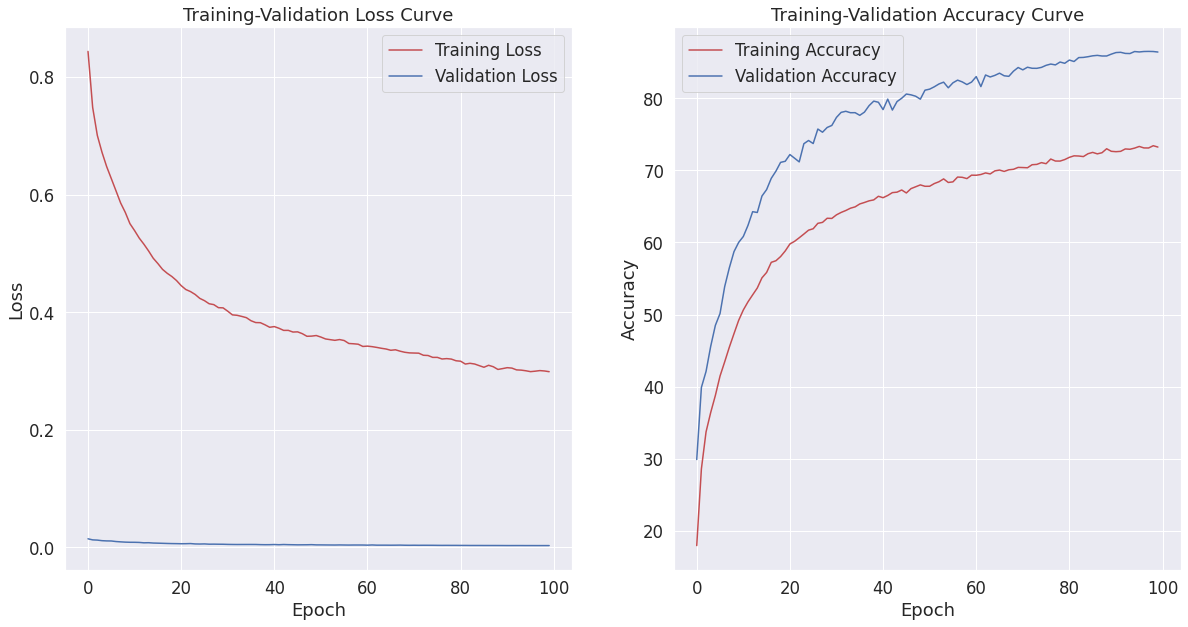

In [21]:
import seaborn as sns

sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(np.array([x/1000 for x in train_losses ]), 'r', label="Training Loss")
plt1.plot(np.array(test_losses), 'b', label="Validation Loss")
plt2.plot(np.array(train_accuracy), 'r', label="Training Accuracy")
plt2.plot(np.array(test_accuracy), 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()

### **Class Wise Performance**

In [22]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images["image"].to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 87 %
Accuracy of   car : 93 %
Accuracy of  bird : 80 %
Accuracy of   cat : 68 %
Accuracy of  deer : 85 %
Accuracy of   dog : 76 %
Accuracy of  frog : 87 %
Accuracy of horse : 85 %
Accuracy of  ship : 97 %
Accuracy of truck : 94 %
